## We create the selected Extra Trees Classifier model from PyCaret

In [132]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [101]:
import warnings
#warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [207]:
%%time

#Load data
#Extract the first 200,000 rows
zf = zipfile.ZipFile('data/jane-street-market-prediction.zip') 
df_train = pd.read_csv(zf.open('train.csv'), nrows=100000)

Wall time: 8.71 s


In [24]:
#df_train.info()

In [208]:
##PREPROCESING##

# Drop rows with 'weight'=0 
df_train = df_train[df_train['weight']!=0]
#df_train = df_train.loc[df_train.weight != 0]

# Create 'action' column (target)
# The objetive is maximise the utility function pi=∑j(weightij∗respij∗actionij) where positive values of resp will increase pi
#df_train['action'] = df_train['resp'].apply(lambda x:x>0).astype(int)
df_train['action'] = (df_train['resp'] > 0).astype('int')

#Select the model´s variables (features alone)
features = [c for c in df_train.columns if 'feature' in c]
#df_train = pd.concat([df_train[features],df_train.action], axis=1)

X = df_train[features]
y = df_train['action']

In [104]:
# Train and test data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [105]:
#First estrategy
#Fill nan values with 0
train_x.fillna(0,inplace=True)
test_x.fillna(0,inplace=True)

#Second estrategy
#Fill nan values with median
#train_median = train_x.median()
#train_x = train_x.fillna(train_median)
#test_x = test_x.fillna(train_median)

#Third estrategy
#Lineal Interpolation
#train_x.interpolate(method='linear', inplace=True)

In [106]:
train_x.isnull().sum().sum()

0

In [107]:
#Check that we have removed all other null and infinite values
train_x.replace([np.inf, -np.inf], np.nan, inplace=True)

In [108]:
#We make sure the values are numeric
train_x.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [15]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print("La matriz de confusión es ")
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

In [109]:
# define the model from PyCaret Optimization
etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7870, verbose=0,
                     warm_start=False)

La matriz de confusión es 
[[26212     0]
 [    0 28219]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


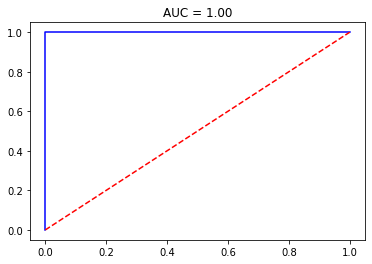

In [110]:
etc.fit(train_x, train_y)
y_pred = etc.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[7219 3891]
 [3415 8803]]
Precisión: 0.6868141289437586
Exactitud: 0.6934772333385851
Exhaustividad: 0.7204943525945326
F1: 0.7067276814386642
AUC: 0.6851346650461411


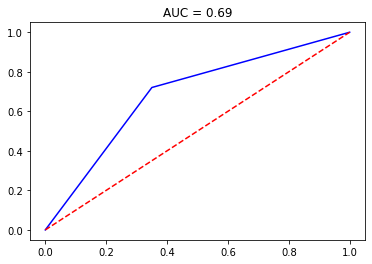

In [111]:
#Check Overfitting in tets df
y_pred_test = etc.predict(test_x)
metricas_modelos(test_y, y_pred_test)

We see that there is **overfit** so we try it with a **cross-validation** and all records.

### Cross Validation
Note: In this case a typical error is to use the previously separated training datasets. Because cross-validation already performs data separation in the specified number of sets and validates with data that the model has not seen, **all data** must be used.

In [209]:
#Preprocessing
#Fill inf values with nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)
#Fill nan values with 0
X.fillna(0,inplace=True)
y.fillna(0,inplace=True)

In [113]:
%%time
# evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.703 (0.006)
Wall time: 5min 2s


La matriz de confusión es 
[[17572 19750]
 [16665 23772]]
Precisión: 0.531694080427989
Exactitud: 0.5462065162446579
Exhaustividad: 0.5878774389791528
F1: 0.56627639681273
AUC: 0.5293494691814472


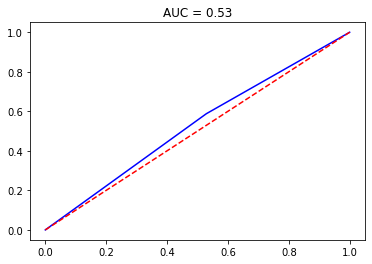

In [118]:
#We represent Accuracy and AUC over 100,000 rows of dataframe
y_pred_cv = cross_val_predict(etc,
                         X,
                         y,
                         cv = 10)

metricas_modelos(y, y_pred_cv)

In [119]:
print(train_x.shape)
print(test_x.shape)

(54431, 130)
(23328, 130)


La matriz de confusión es 
[[16850  9362]
 [ 8051 20168]]
Precisión: 0.6800903896676527
Exactitud: 0.6829664747714189
Exhaustividad: 0.7146957723519615
F1: 0.6984709691942718
AUC: 0.6787655574715705


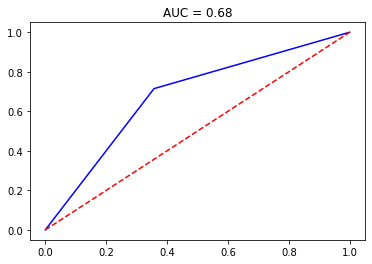

In [122]:
#We represent Accuracy Accuracy and AUC over 54,431 rows of train df
y_pred_cv = cross_val_predict(etc,
                         train_x,
                         train_y,
                         cv = 10)

metricas_modelos(train_y, y_pred_cv)

La matriz de confusión es 
[[6316 4794]
 [3800 8418]]
Precisión: 0.6316015089163237
Exactitud: 0.6371480472297911
Exhaustividad: 0.6889834670158782
F1: 0.6620526936688951
AUC: 0.6287401583504234


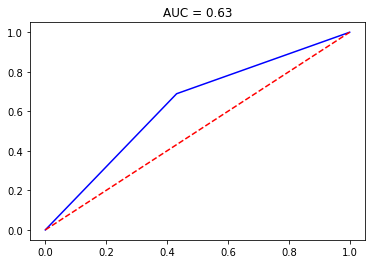

In [121]:
#Tested performance on df test selection (23,328 records)
y_pred_cv = cross_val_predict(etc,
                         test_x,
                         test_y,
                         cv = 10)

metricas_modelos(test_y, y_pred_cv)


Optimizamos los parámetros del modelo con validación cruzada desde `GridSearchCV`

In [ ]:
#Original model parameters
etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7870, verbose=0,
                     warm_start=False)

In [123]:
%%time

import warnings
#warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

#model = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=25,
#                            min_samples_leaf=35, max_features=150)

cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(
    estimator=etc,
    param_grid={
        'criterion': ['entropy'],#['gini', 'entropy'], #grid.best_params_ = {'criterion': 'entropy'}
        'n_estimators': [100],#range(25,125,25),#grid.best_params_ = {'n_estimators': 100}
        'max_depth': [100], #range(1,100,25),#grid.best_params_ = {'max_depth': 100}
        'max_features': [100],#range(50,150,50),#grid.best_params_ = {'n_estimators': 100}
        #'min_samples_leaf': range(1,50,5),#grid.best_params_ = {'min_samples_leaf': 1}
        #'min_samples_split': range(1,50,5),
    },
    #scoring='r2',
    cv=cv2
        
)

grid.fit(X, y)
print(u'El rendimiento el modelo es: %0.5f' % grid.score(X, y))

El rendimiento el modelo es: 1.00000
Wall time: 32min 57s


In [191]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.762):
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'n_estimators': 100}


In [125]:
print(u'El rendimiento el modelo es: %0.5f' % grid.best_score_)

El rendimiento el modelo es: 0.76218


In [126]:
%%time

model_et = ExtraTreesClassifier(**grid.best_params_)

model_et.fit(X, y)

Wall time: 3min 49s


ExtraTreesClassifier(criterion='entropy', max_depth=100, max_features=100)

### Automate the process with Pipeline

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77759 entries, 1 to 99999
Columns: 130 entries, feature_0 to feature_129
dtypes: float64(129), int64(1)
memory usage: 77.7 MB


In [128]:
#transformations that we apply to numeric variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#If you want to select a particular type of Column
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
#categorical_features = X.select_dtypes(include=['object']).drop(['action'], axis=1).columns

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])
        #('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)])

In [129]:
%%time

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_et)])

#pipe = Pipeline([('model', model)])

pipe.fit(X, y)

pipe.score(test_x, test_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(X, y))

El rendimiento el modelo es: 1.00000
Wall time: 3min 53s


La matriz de confusión es 
[[26212     0]
 [    0 28219]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


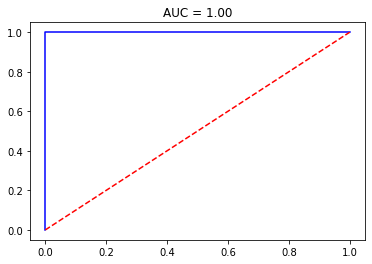

In [130]:
#Check with train and test set to see if there is overfit in model performance
y_pred = pipe.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[11110     0]
 [    0 12218]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


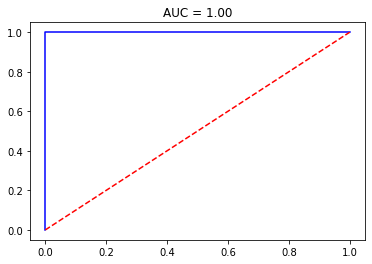

In [131]:
#Check overfit in the df test
y_pred_test = pipe.predict(test_x)
metricas_modelos(test_y, y_pred_test)

### Selection of the best features

In order to generalize the model and improve processing times we can introduce as a transformer within the Pipeline, a selector of the **best features** `SelectKBest` to check if we get similar yields.

In [133]:
X.shape

(77759, 130)

In [134]:
#Selection of the 50 most predictive features 
X_new = SelectKBest(f_classif, k=50).fit_transform(X, y)
X_new.shape

(77759, 50)

In [140]:
#Repeat for feature selection. For that you have to separate SelectKBest from fit_transform
var_sk = SelectKBest(f_classif, k = 50)
var_sk.fit_transform(X, y)
#var_sk.get_support()

k_selection = X.loc[:, var_sk.get_support()]

In [145]:
k_selection.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_13', 'feature_15', 'feature_17',
       'feature_18', 'feature_19', 'feature_21', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28',
       'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'feature_53', 'feature_55', 'feature_57',
       'feature_58', 'feature_59', 'feature_69', 'feature_70', 'feature_71',
       'feature_79', 'feature_103', 'feature_122', 'feature_126',
       'feature_128'],
      dtype='object')

Fit model with the selected features

In [151]:
select_features = list(k_selection.columns)
t = [('num', SimpleImputer(strategy='median'), select_features), ('scaler', StandardScaler(), select_features)]
transformer = ColumnTransformer(transformers=t)

In [152]:
%%time
pipe = Pipeline(steps=[('transformer', transformer),
                       ('model', model_et)])

pipe.fit(X, y)

pipe.score(test_x, test_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(X, y))

El rendimiento el modelo es: 1.00000
Wall time: 3min 58s


La matriz de confusión es 
[[26212     0]
 [    0 28219]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


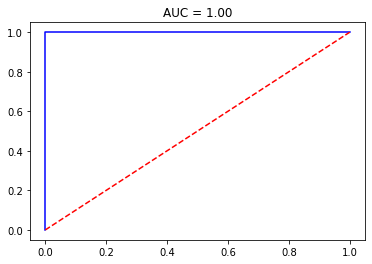

In [153]:
#Test with train and test set to see if there is overfit in model performance
y_pred = pipe.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[11110     0]
 [    0 12218]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


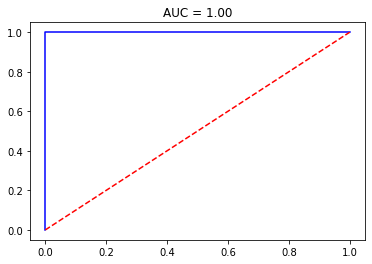

In [154]:
#We see if there is overfit in the df test
y_pred_test = pipe.predict(test_x)
metricas_modelos(test_y, y_pred_test)

### Feature selection with PCA (principal component analysis)
Reference: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [181]:
from sklearn.decomposition import PCA, NMF

#Repeat for feature selection. For that you have to separate SelectKBest from fit_transform
pca_sk = PCA(.90) #Divide into components that explain at least 90% of the variance (information)
pca_sk.fit_transform(X, y)
#var_sk.get_support()

#k_selection = X.loc[:, pca_sk.get_support()]
#k_selection.columns
pca_sk.explained_variance_ratio_
#To explain 90% of the variance is reduced from 130 characteristics to 16 components
print('Nº de componentes reducidas para explicar el 90% de la varianza:', len(pca_sk.explained_variance_ratio_))
print('% de reducción', )

Nº de componentes reducidas para explicar el 90% de la varianza: 16


In [182]:
pca = PCA()
pca.get_params().keys()

dict_keys(['copy', 'iterated_power', 'n_components', 'random_state', 'svd_solver', 'tol', 'whiten'])

In [183]:
et = ExtraTreesClassifier()
et.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [185]:
%%time

pca= PCA()
et = ExtraTreesClassifier()

pipe_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('model', et)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': range(4,16,4),
}

search = GridSearchCV(pipe_pca, param_grid=param_grid, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.519):
{'pca__n_components': 12}
Wall time: 1min 14s


In [210]:
%%time

pca= PCA(n_components=12)
et = ExtraTreesClassifier(criterion='entropy', random_state=0, n_estimators=100)

cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

pipe_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('model', et)])

# Parameters of pipelines can be set using name +‘__’+ parameter names:
param_grid = {
    #'pca__n_components': range(4,16,4),
    #'et__criterion': ['entropy'],#['gini', 'entropy'], #grid.best_params_ = {'criterion': 'entropy'}
    #'n_estimators': [50, 100],#range(25,125,25),#grid.best_params_ = {'n_estimators': 100}
    'model__max_depth': [1, 5, 25, 50], #range(1,100,25),#grid.best_params_ = {'max_depth': 100}
     #'max_features': [100],#range(50,150,50),#grid.best_params_ = {'n_estimators': 100}
     #'min_samples_leaf': range(1,50,5),#grid.best_params_ = {'min_samples_leaf': 1}
     #'min_samples_split': range(1,50,5),
    #'et__random_state': [0]
}

et_pca = GridSearchCV(pipe_pca, param_grid=param_grid, n_jobs=-1, cv=cv2)
et_pca.fit(X, y)
print("Best parameter (CV score=%0.3f):" % et_pca.best_score_)
print(et_pca.best_params_)

Best parameter (CV score=0.578):
{'model__max_depth': 50}
Wall time: 7min 20s


Reduced processing time from 3min 58s with the `BestKselection` method with 50 features to 1min 14s with the `PCA` method with 12 components.

In [192]:
#To get the reference parameters of the different methods
grid_red.get_params().keys()
search.get_params().keys()
pipe_pca.get_params().keys()
ExtraTreesClassifier().get_params().keys()
#etc

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

La matriz de confusión es 
[[22547  3665]
 [  278 27941]]
Precisión: 0.9275596626922158
Exactitud: 0.8840410048724926
Exhaustividad: 0.9901484815195436
F1: 0.9340910990388633
AUC: 0.9251635128488913


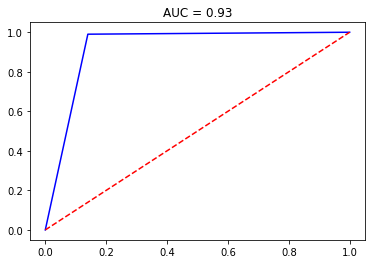

In [203]:
#Test with train and test set to see if there is overfit in model performance
y_pred = et_pca.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[ 9548  1562]
 [  143 12075]]
Precisión: 0.926911865569273
Exactitud: 0.8854586785949989
Exhaustividad: 0.9882959567850712
F1: 0.9340553084509765
AUC: 0.9238509486895653


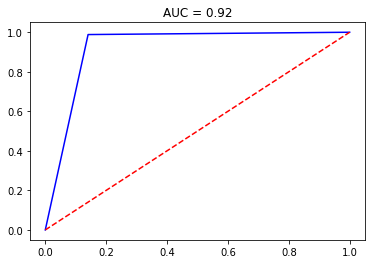

In [204]:
#We see if there is overfit in the df test
y_pred_test = et_pca.predict(test_x)
metricas_modelos(test_y, y_pred_test)